># A framework to estimate Chorus waves (Chorus wave global maps) in from low-Earth-orbit, Van Allen Probe and other datasets.

>- September, 2021. S. Chakraborty(<shibaji7@vt.edu>), G. S. Cunninghum
>- Data Analysis for one month worth data for GMM study

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import numpy as np

def get_gridded_parameters(q, xparam, yparam, zparam, r=0):
    plotParamDF = q[ [xparam, yparam, zparam] ]
    plotParamDF[xparam] = np.round(plotParamDF[xparam].tolist(), r)
    plotParamDF[yparam] = np.round(plotParamDF[yparam].tolist(), r)
    plotParamDF = plotParamDF.groupby( [xparam, yparam] ).mean().reset_index()
    plotParamDF = plotParamDF[ [xparam, yparam, zparam] ].pivot( xparam, yparam )
    x = plotParamDF.index.values
    y = plotParamDF.columns.levels[1].values
    X, Y  = np.meshgrid( x, y )
    # Mask the nan values! pcolormesh can't handle them well!
    Z = np.ma.masked_where(
            np.isnan(plotParamDF[zparam].values),
            plotParamDF[zparam].values)
    return X,Y,Z

def contour_f(x, y, z, ax, xlab, ylab):
    ax.contourf(x, y, z.T, cmap="RdGy")
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    return

In [2]:
# Get and preprocess the whole dataset
inputs = ["MLAT", "MLT", "L", "Lstar", "AE", "mod"]
outputs = ["log.B(pT)"]
dat = pd.read_csv("tmp/20121001_20121031.csv", parse_dates=["epoch"])
dat["mod"] = dat.epoch.apply(lambda x: x.hour*60 + x.minute) # Define minute of a day
dat["sod"] = dat.epoch.apply(lambda x: x.hour*3600 + x.minute*60 + x.second) # Define seconds of a day
dat["log.B(pT)"] = np.log10(dat["B(pT)"])
dat.head()

/home/shibaji/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,epoch,SAT,L,Lstar,R,MLAT,MLON,MLT,Fce,Bl(pT),Bu(pT),B(pT),AE,mod,sod,log.B(pT)
0,2012-10-01 00:00:00,A,6.103,5.661,-8.740,10.236,176.200,7.047,3479.59,84.118,1.890,84.155,448,0,0,1.925080
1,2012-10-01 00:01:00,A,6.105,5.663,-8.875,10.295,176.110,7.057,3476.28,101.134,1.259,101.139,442,1,60,2.004919
2,2012-10-01 00:02:00,A,6.107,5.665,-9.010,10.354,176.021,7.068,3473.19,183.556,2.911,183.596,454,2,120,2.263863
3,2012-10-01 00:03:00,A,6.109,5.667,-9.145,10.413,175.931,7.079,3470.31,82.164,1.063,82.175,470,3,180,1.914740
4,2012-10-01 00:04:00,A,6.111,5.668,-9.280,10.472,175.841,7.089,3467.64,151.897,2.066,151.906,484,4,240,2.181575


In [3]:
# Describe the whole dataset
dat[inputs+outputs].describe()

,MLAT,MLT,L,Lstar,AE,mod,log.B(pT)
count,89065.000000,89065.000000,89065.000000,89054.000000,89280.000000,89280.000000,8.906500e+04
mean,0.541396,7.611744,4.406853,4.185021,154.685349,719.500000,-inf
std,7.157897,4.324994,1.515970,1.355061,204.243427,415.694422,NaN
min,-19.621000,0.090000,0.999000,1.107000,4.000000,0.000000,-inf
25%,-4.314000,5.125000,3.319000,3.276250,36.000000,359.750000,3.941412e-02
50%,-1.726000,6.804000,4.899000,4.658000,66.000000,719.500000,2.301934e-01
75%,4.586000,8.793000,5.720000,5.328000,185.000000,1079.250000,7.546541e-01
max,19.813000,24.000000,6.363000,5.882000,1955.000000,1439.000000,3.227419e+00


In [4]:
# Drop nan and infinitites
dat = dat[~dat.isin([np.nan, np.inf, -np.inf]).any(1)]
# Describe the whole dataset
dat[inputs+outputs].describe()

,MLAT,MLT,L,Lstar,AE,mod,log.B(pT)
count,78948.000000,78948.000000,78948.000000,78948.000000,78948.000000,78948.000000,78948.000000
mean,0.618530,6.563765,4.782607,4.530025,154.370434,718.195344,0.550225
std,7.186077,2.418297,1.156908,1.005971,202.794572,415.214119,0.616235
min,-18.654000,0.090000,2.025000,2.032000,4.000000,0.000000,-0.413413
25%,-4.394000,5.001000,3.964000,3.855000,36.000000,356.000000,0.106871
50%,-2.037000,6.535500,5.144000,4.860000,65.000000,713.000000,0.314920
75%,4.818000,8.080000,5.772000,5.369000,185.000000,1074.000000,0.839179
max,19.813000,24.000000,6.363000,5.882000,1955.000000,1439.000000,3.227419


Text(0, 0.5, 'Values(params)')

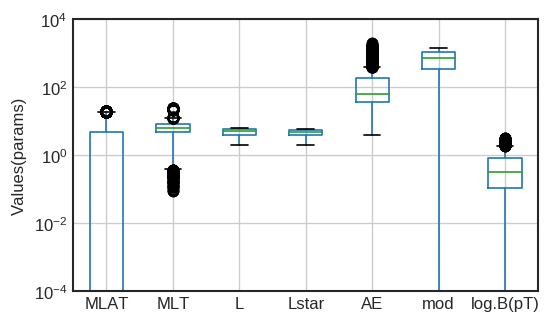

In [5]:
# Generate the boxplots
fig = plt.figure(dpi=120, figsize=(5,3))
ax = fig.add_subplot(111)
dat[inputs+outputs].boxplot(ax=ax)
ax.set_yscale("log")
ax.set_ylim(1e-4, 1e4)
ax.set_ylabel("Values(params)")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdec970dfd0>,
      dtype=object)

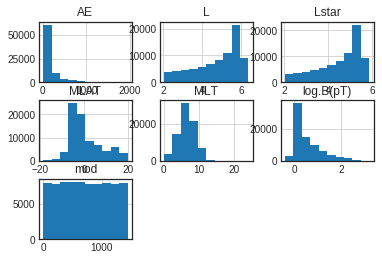

In [6]:
# Generate the histograms
#fig = plt.figure(dpi=120, figsize=(6,6))
dat[inputs+outputs].hist()
#fig.subplots_adjust(wspace=0.5, hspace=0.5)

/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/shibaji/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


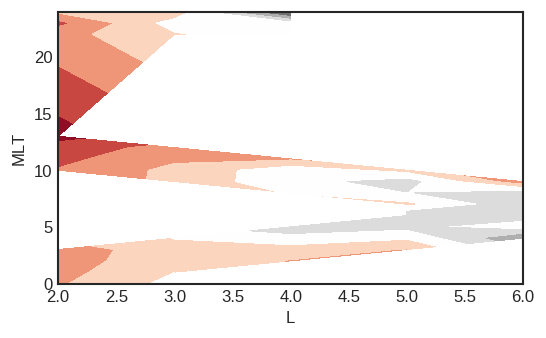

In [7]:
fig = plt.figure(dpi=120, figsize=(5,3))
ax = fig.add_subplot(111)
x, y, z = get_gridded_parameters(dat, "L", "MLT", outputs[0])
contour_f(x, y, z, ax, xlab="L", ylab="MLT")